In [1]:
# Clustering Notebook
# =====================================
# Importar librerías


import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch


ModuleNotFoundError: No module named 'pandas'

In [2]:
%load_ext kedro.ipython

df = catalog.load("data_final")

ModuleNotFoundError: No module named 'kedro'

In [3]:
# =====================================
# 2. Preprocesamiento
def preprocess_data(df: pd.DataFrame):
    df_limits = df.head(7000)
    X = df_limits[['mapname', 'operator', 'primaryweapon']]

    encoder = OneHotEncoder(sparse_output=True)
    X_encoded = encoder.fit_transform(X)

    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_encoded)

    X_scaled_df = pd.DataFrame(X_scaled.toarray() if hasattr(X_scaled, "toarray") else X_scaled)
    return X_scaled_df, encoder, scaler

X_scaled, encoder, scaler = preprocess_data(df)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,5.399012,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.991758,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.991758,0.0,...,0.0,0.0,0.0,0.0,4.268343,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [4]:
# =====================================
# 3. PCA (85% de varianza)
def apply_pca(X_scaled: pd.DataFrame, explained_var: float = 0.85):
    pca = PCA(n_components=explained_var)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca

X_pca, pca_model = apply_pca(X_scaled)


print("Varianza explicada total:", sum(pca_model.explained_variance_ratio_))

Varianza explicada total: 0.865573158729392


In [5]:
# --- 4c. Jerárquico (Agglomerative)
from sklearn.cluster import AgglomerativeClustering

def apply_hierarchical(X_pca: pd.DataFrame, n_clusters=5, linkage="ward"):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X_pca)
    return labels

labels_hierarchical = apply_hierarchical(X_pca, n_clusters=5)
print("Número de clusters Jerárquico:", len(set(labels_hierarchical)))

Número de clusters Jerárquico: 5


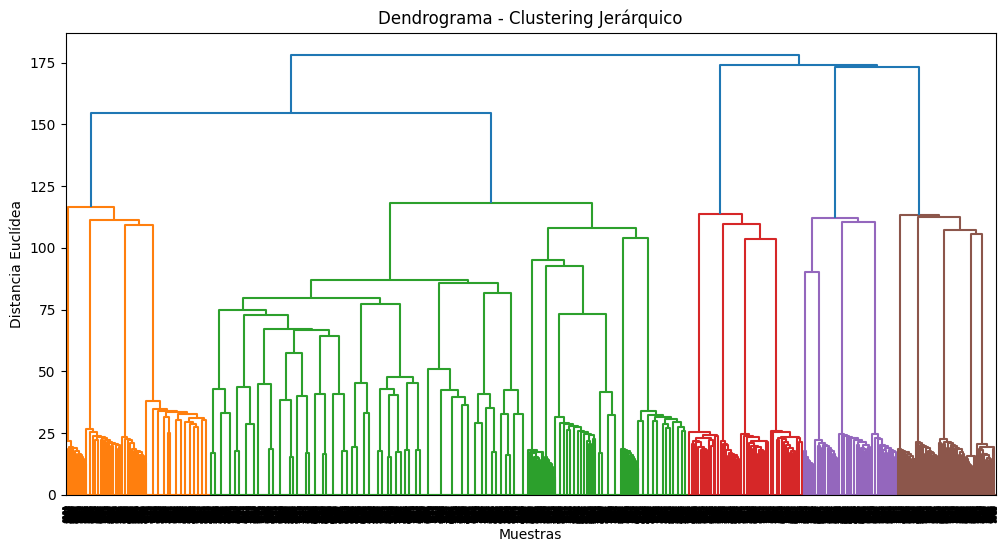

In [6]:
# Dendrograma para clustering jerárquico
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_pca, method='ward'))
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia Euclídea')
plt.show()

In [7]:
# Función para calcular métricas de clustering
def compute_clustering_metrics_hierarchical(X_pca, labels_hierarchical):
    if len(set(labels_hierarchical)) <= 1:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None
        }
    return {
        "silhouette": silhouette_score(X_pca, labels_hierarchical),
        "davies_bouldin": davies_bouldin_score(X_pca, labels_hierarchical),
        "calinski_harabasz": calinski_harabasz_score(X_pca, labels_hierarchical)
    }

# Calcular métricas del modelo jerárquico
metrics_hierarchical = compute_clustering_metrics_hierarchical(X_pca, labels_hierarchical)

# Convertir a DataFrame para visualizar
metrics_df = pd.DataFrame([metrics_hierarchical], index=["Jerárquico"])
print(metrics_df)


            silhouette  davies_bouldin  calinski_harabasz
Jerárquico    0.121725        2.498883         459.366565


In [8]:
# Función para calcular varianza intra-cluster
def cluster_variance_hierarchical(X_pca, labels_hierarchical):
    clusters = np.unique(labels_hierarchical)
    var_per_cluster = {}

    for c in clusters:
        points = X_pca[labels_hierarchical == c]
        var_per_cluster[c] = np.var(points, axis=0).sum()  # suma de varianzas por componente

    return var_per_cluster

# Calcular varianza del modelo jerárquico
var_hierarchical = cluster_variance_hierarchical(X_pca, labels_hierarchical)
print("Varianza intra-cluster Jerárquico:", sum(var_hierarchical.values()))


Varianza intra-cluster Jerárquico: 174.73099231588895


In [9]:


# Crear DataFrame con PC1 y PC2
pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df["hierarchical"] = labels_hierarchical

# Convertir etiquetas a string para plotly
pca_df["cluster"] = pca_df["hierarchical"].astype(str)

# Gráfico
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="cluster",
    opacity=0.6,
    labels={"cluster": "Cluster"},
    title="PCA 2D - Clustering Jerárquico"
)

fig.update_traces(marker=dict(size=6))
fig.update_layout(height=600, width=800)

fig.show()


In [17]:
import numpy as np
from sklearn.metrics import pairwise_distances

def detect_anomalies_hierarchical(X_pca, labels_hierarchical, percentile=95):
    distances = np.zeros(len(X_pca))

    # Calcular distancia mínima al vecino dentro del mismo cluster
    for c in np.unique(labels_hierarchical):
        cluster_idx = np.where(labels_hierarchical == c)[0]
        cluster_points = X_pca[cluster_idx]

        if len(cluster_points) <= 1:
            continue

        dist_matrix = pairwise_distances(cluster_points)
        np.fill_diagonal(dist_matrix, np.inf)

        distances[cluster_idx] = dist_matrix.min(axis=1)

    # Determinar umbral
    threshold = np.percentile(distances, percentile)

    # Vector booleano de anomalías
    anomalies = distances > threshold

    # Mostrar resultado
    print("Número de anomalías detectadas (Jerárquico):", anomalies.sum())
    print("Umbral usado:", threshold)

    return anomalies


anom_hierarchical = detect_anomalies_hierarchical(X_pca, labels_hierarchical)


Número de anomalías detectadas (Jerárquico): 255
Umbral usado: 1.6858739404357614e-07


In [18]:
import plotly.express as px
import pandas as pd


pca_df_h = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df_h["cluster"] = labels_hierarchical.astype(str)        # clusters jerárquicos
pca_df_h["anomalia"] = anom_hierarchical.astype(int)         # 0 normal, 1 anomalía


pca_df_h["label_plot"] = pca_df_h.apply(
    lambda row: f"c{row['cluster']}" if row["anomalia"] == 0 else "anomalia",
    axis=1
)


fig_h = px.scatter(
    pca_df_h,
    x="PC1",
    y="PC2",
    color="label_plot",
    opacity=0.55,
    labels={"label_plot": "Cluster / Anomalía"},
)

fig_h.update_traces(marker=dict(size=5))
fig_h.update_layout(
    title="PCA 2D - Jerárquico con Detector de Anomalías",
    height=500,
    width=600,
    legend_title_text="Cluster / Estado"
)

fig_h.show()

## Conclusión 

El clustering jerárquico nos brindó una perspectiva más interpretativa del dataset, ya que el dendrograma permitió visualizar cómo se agrupan y se relacionan progresivamente los puntos. Este enfoque nos ayudó a comprender la estructura interna de los datos antes de fijar una cantidad definitiva de clusters, lo que reforzó varias decisiones tomadas en los otros modelos.

Si bien observamos que el método tiende a ser menos robusto ante ruido y outliers, y que su costo computacional puede aumentar con datasets más grandes, su valor principal estuvo en la claridad visual y en la capacidad de explorar distintas profundidades de agrupamiento. En nuestro caso, el modelo ofreció clusters coherentes y sirvió como validación adicional del número de grupos identificados con K-Means y DBSCAN.